#### Import necessary libraries

In [17]:
import os
import numpy as np
import librosa
from scipy.io import wavfile
import IPython.display as ipd
import warnings

warnings.filterwarnings("ignore")

In [18]:
pwd

'/Users/abhilashalodha/Documents/Speech2Text-Project'

#### Keep the directory structure as 
Speech2Text-Project
    - data (folder)
    - model (folder)
    - sample (folder)
    - Speech2Text-Project.ipynb (notebook file)
    
Download the data from https://www.kaggle.com/c/tensorflow-speech-recognition-challenge and keep train/audio files in data folder

In [20]:
labels=os.listdir(audio_data_path)
labels

['right', 'go', 'no', 'left', 'stop', 'up', 'down', 'yes', 'on', 'off']

#### Exploring the data

In [21]:
audio_data_path = 'data/'
samples, sample_rate = librosa.load(audio_data_path + 'right'+ '/' + '0a7c2a8d_nohash_0.wav')

In [22]:
samples

array([-9.6768628e-05, -3.0657952e-04, -3.6889483e-04, ...,
        2.1641637e-04,  2.7139651e-04,  2.1467611e-04], dtype=float32)

In [23]:
sample_rate

22050

In [24]:
ipd.Audio(samples, rate=sample_rate)

#### Data-preprocessing
We'll resample the sampling rate of the audio files to 8000 Hz.

In [26]:
final_audio = []
final_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(audio_data_path + label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(audio_data_path + label + '/' + wav)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            final_audio.append(samples)
            final_label.append(label)

right
go
no
left
stop
up
down
yes
on
off


In [31]:
len(final_audio)

21312

In [29]:
len(final_label)

21312

Since it's a multi-class classification problem, we'll do one-hot-encoding over the labels.

In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(final_label)
classes= list(le.classes_)

In [33]:
classes

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

In [34]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [35]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Since the input to a conv1D is a 3D array, we'll reshape all audio files from 2D to 3D.

In [36]:
final_audio = np.array(final_audio).reshape(-1,8000,1)

**Train and validation set preparation**

We'll consider 75% data for training set and 25% for validation set.


In [37]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(final_audio),np.array(y),stratify=y,test_size = 0.25,random_state=777,shuffle=True)

**Model Architecture** 

In [38]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.25)(conv)

#Dense Layer 2
conv = Dense(64, activation='relu')(conv)
conv = Dropout(0.25)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [39]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
mc = ModelCheckpoint('model/speech2text.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#### Model Training

In [40]:
history=model.fit(x_tr, y_tr ,epochs=30, callbacks=[mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/30
500/500 [==============================] - ETA: 0s - loss: 2.0181 - accuracy: 0.2402
Epoch 00001: val_accuracy improved from -inf to 0.41967, saving model to model/speech2text.hdf5
500/500 [==============================] - 106s 212ms/step - loss: 2.0181 - accuracy: 0.2402 - val_loss: 1.5987 - val_accuracy: 0.4197
Epoch 2/30
500/500 [==============================] - ETA: 0s - loss: 1.5077 - accuracy: 0.4572
Epoch 00002: val_accuracy improved from 0.41967 to 0.53341, saving model to model/speech2text.hdf5
500/500 [==============================] - 108s 216ms/step - loss: 1.5077 - accuracy: 0.4572 - val_loss: 1.3214 - val_accuracy: 0.5334
Epoch 3/30
500/500 [==============================] - ETA: 0s - loss: 1.2636 - accuracy: 0.5527
Epoch 00003: val_accuracy improved from 0.53341 to 0.62913, saving model to model/speech2text.hdf5
500/500 [==============================] - 107s 214ms/step - loss: 1.2636 - accuracy: 0.5527 - val_loss: 1.1229 - val_accuracy: 0.6291
Epoch 4/30
50

Epoch 28/30
500/500 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.8671
Epoch 00028: val_accuracy did not improve from 0.79842
500/500 [==============================] - 112s 224ms/step - loss: 0.3846 - accuracy: 0.8671 - val_loss: 0.7420 - val_accuracy: 0.7864
Epoch 29/30
500/500 [==============================] - ETA: 0s - loss: 0.3819 - accuracy: 0.8687
Epoch 00029: val_accuracy did not improve from 0.79842
500/500 [==============================] - 110s 220ms/step - loss: 0.3819 - accuracy: 0.8687 - val_loss: 0.7330 - val_accuracy: 0.7947
Epoch 30/30
500/500 [==============================] - ETA: 0s - loss: 0.3739 - accuracy: 0.8734
Epoch 00030: val_accuracy did not improve from 0.79842
500/500 [==============================] - 124s 248ms/step - loss: 0.3739 - accuracy: 0.8734 - val_loss: 0.7092 - val_accuracy: 0.7975


**Plotting loss and accuracy graphs wrt epochs**

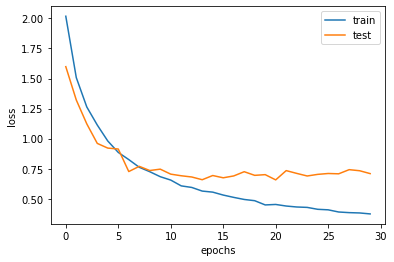

In [50]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

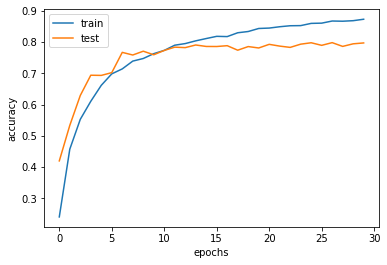

In [51]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

#### **Loading the saved model**
The saved model lies in "model" directory

In [46]:
from tensorflow.keras.models import load_model
model=load_model('model/speech2text.hdf5')

#### Doing predictions
Selecting an audio file randomly from the validation set and predicting it's text.

In [52]:
import random
index=random.randint(0,len(x_val)-1)
print("Index::",index)
samples=x_val[index].ravel()
print("Audio::",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Index:: 4343
Audio:: left


In [53]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [55]:
print("Text::",predict(samples))

Text:: left


Predicting the text of test dataset i.e. an audio file placed in "sample" directory.

In [56]:
filepath='sample'

In [61]:
#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'right.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)              

In [62]:
samples.shape

(8000,)

In [63]:
#converting voice commands to text
predict(samples)

'right'